In [17]:
!pip install pims_nd2

2430.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 4.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pims_nd2: filename=pims_nd2-1.1-py3-none-any.whl size=19778382 sha256=9565dedda9cd6296a653167ac95803cdf0a97d8bea62a14052905f4e18cbeec3
  Stored in directory: /Users/user/Library/Caches/pip/wheels/57/c3/f7/800b88f7584a1ad067d2ebe91e2edbc4c9cf3c603a3b0251ac
Successfully built pims_nd2


In [1]:
from cellpose import models, io
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imsave

Total frames: 37


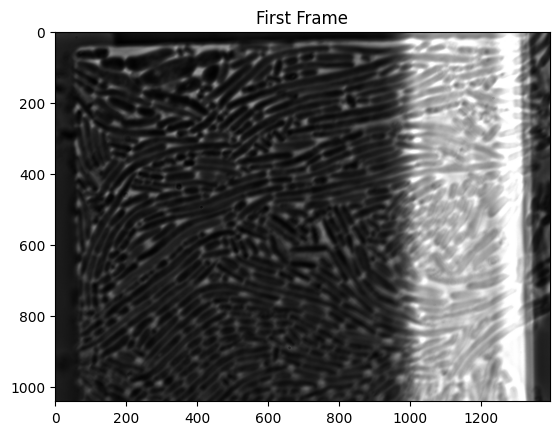

In [3]:

from nd2reader import ND2Reader

# Open the ND2 file
nd2_file = "/Applications/Oliveira Lab Projects/nd2-analyzer/datasets/ND2/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"

# Load the ND2 file (without closing it immediately)
images = ND2Reader(nd2_file)

# Check the total number of frames
print(f"Total frames: {len(images)}")

# Display the first frame
plt.imshow(images[0], cmap="gray")
plt.title("First Frame")
plt.show()

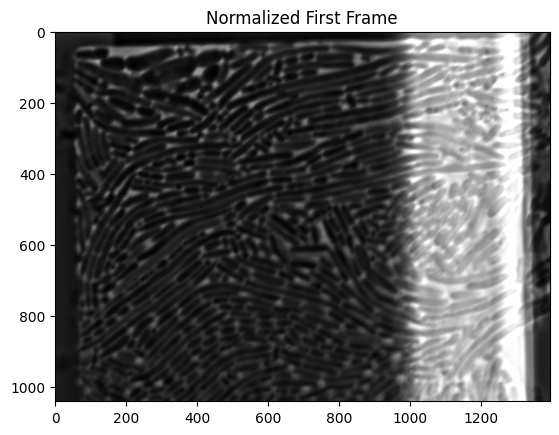

In [4]:
# Normalize the first frame
first_frame = images[0] 
normalized_frame = (first_frame - np.min(first_frame)) / (np.max(first_frame) - np.min(first_frame))

plt.imshow(normalized_frame, cmap="gray")
plt.title("Normalized First Frame")
plt.show()

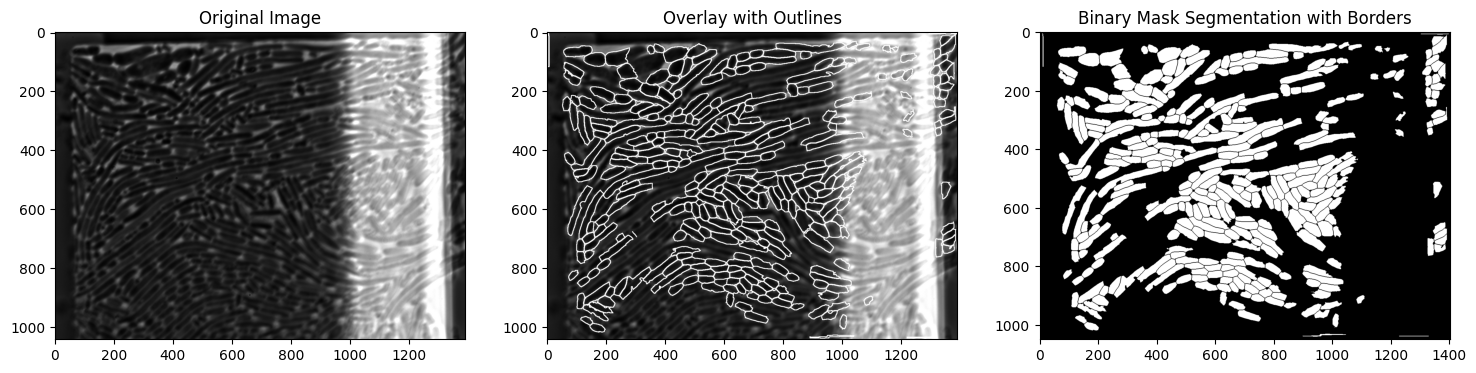

In [5]:
from cellpose import models, utils
from skimage.restoration import richardson_lucy
from scipy.ndimage import gaussian_filter, binary_dilation
from nd2reader import ND2Reader
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt


def load_nd2_file(nd2_file):
    """
    Load the first frame of an ND2 file and normalize it.

    Parameters:
        nd2_file (str): Path to the ND2 file.

    Returns:
        np.ndarray: Normalized frame from the ND2 file.
    """
    with ND2Reader(nd2_file) as images:
        first_frame = images[0]
        normalized_frame = (first_frame - np.min(first_frame)) / (np.max(first_frame) - np.min(first_frame))
    return normalized_frame


def preprocess_image(image):
    """
    Preprocess an image by applying Gaussian blur, CLAHE, and Richardson-Lucy deblurring.

    Parameters:
        image (np.ndarray): Input image.

    Returns:
        np.ndarray: Preprocessed image.
    """
    denoised_frame = gaussian_filter(normalized_frame, sigma=1)

    # Apply CLAHE to improve contrast
    clahe = exposure.equalize_adapthist(denoised_frame, clip_limit=0.03)

    # Step 3: Deblur the image
    psf = np.ones((5, 5)) / 25  # Example PSF
    deblurred_frame = richardson_lucy(denoised_frame, psf, num_iter=30)

    return deblurred_frame


def segment_image(deblurred_frame, model_type="bact_phase_cp3"):
    """
    Segment the preprocessed image using a Cellpose model.

    Parameters:
        image (np.ndarray): Preprocessed image.
        model_type (str): Type of Cellpose model to use.

    Returns:
        tuple: Masks, flows, and styles from the Cellpose model.
    """
    model = models.CellposeModel(model_type=model_type)

    # Step 5: Apply the model to the preprocessed frame
    masks, flows, styles = model.eval(deblurred_frame, diameter=None, channels=[0, 0])
    return masks, flows, styles


def visualize_results(normalized_frame, masks):
    """
    Visualize the original image, overlay with outlines, and binary mask segmentation with borders.

    Parameters:
        normalized_frame (np.ndarray): Original normalized image.
        masks (np.ndarray): Segmentation masks.
    """
    outlines = utils.masks_to_outlines(masks)
    thick_outlines = binary_dilation(outlines, structure=np.ones((3, 3)))
    overlay = normalized_frame.copy()
    overlay[thick_outlines] = 1  # Set outline pixels to white
    
    

    # Generate binary mask
    binary_mask = masks > 0

    # Binary mask with borders
    binary_mask_with_borders = utils.masks_to_outlines(masks)
    binary_mask_display = binary_mask.copy()
    binary_mask_display[binary_mask_with_borders] = 0  # Set border pixels to black
    binary_mask_display = np.pad(binary_mask_display, pad_width=5, mode='constant', constant_values=0)

    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax = ax.ravel()

    # Original Image
    ax[0].imshow(normalized_frame, cmap="gray")
    ax[0].set_title("Original Image")

    # Overlay with Outlines
    ax[1].imshow(overlay, cmap="gray")
    ax[1].set_title("Overlay with Outlines")

    # Binary Mask Segmentation with Borders
    ax[2].imshow(binary_mask_display, cmap="gray")
    ax[2].set_title("Binary Mask Segmentation with Borders")

    plt.show()


# Example Usage
if __name__ == "__main__":
    # Step 1: Load the ND2 file
    nd2_file = "/Applications/Oliveira Lab Projects/nd2-analyzer/datasets/nd2/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"
    normalized_frame = load_nd2_file(nd2_file)

    # Step 2: Preprocess the image
    preprocessed_frame = preprocess_image(normalized_frame)

    # Step 3: Segment the image
    masks, flows, styles = segment_image(preprocessed_frame)

    # Step 4: Visualize the results
    visualize_results(normalized_frame, masks)


Segmenting images using unet model


2025-07-02 17:19:55.117796: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-02 17:19:55.119193: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-02 17:19:55.119213: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-02 17:19:55.119791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-02 17:19:55.120251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-07-02 17:19:57.887019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


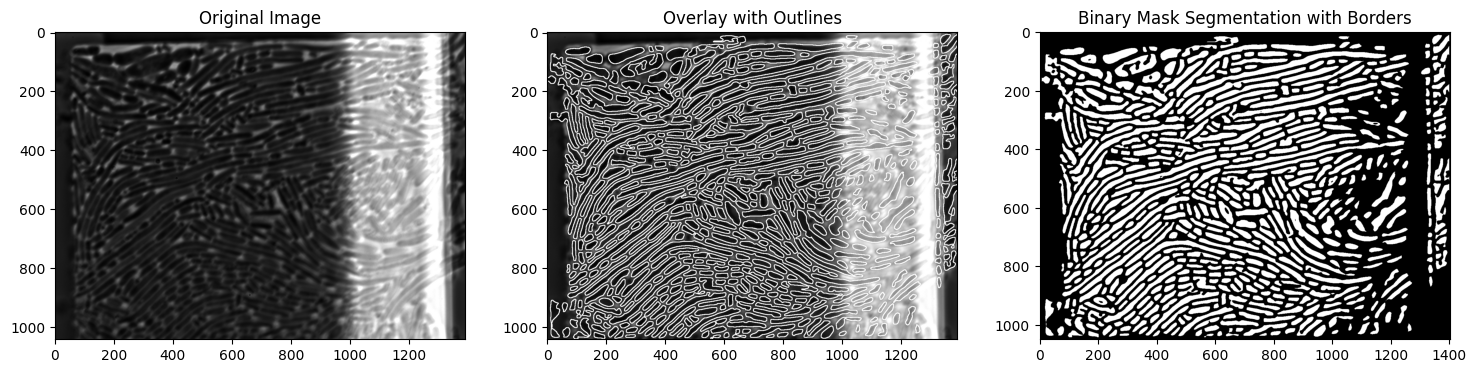

In [6]:
# Replace your segment_image function with this:
def segment_image(deblurred_frame, weights_path):
    """
    Segment the preprocessed image using U-Net model.
    """
    import os
    os.environ["UNET_WEIGHTS"] = weights_path
    
    from src.segmentation.segmentation_models import SegmentationModels
    
    seg_models = SegmentationModels()
    masks = seg_models.segment_images([deblurred_frame], mode=SegmentationModels.UNET)
    
    return masks[0]  # Return the binary mask

# Update your main execution:
if __name__ == "__main__":
    # Step 1: Load the ND2 file
    nd2_file = "/Applications/Oliveira Lab Projects/nd2-analyzer/datasets/nd2/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2"
    normalized_frame = load_nd2_file(nd2_file)

    # Step 2: Preprocess the image
    preprocessed_frame = preprocess_image(normalized_frame)

    # Step 3: Segment with U-Net (replace this line)
    weights_path = "/Users/user/Desktop/Amby-Oliveira Lab/training_checkpoints/delta_2_20_02_24_600eps"  # Update this path
    binary_mask = segment_image(preprocessed_frame, weights_path)

    # Step 4: Visualize (update this function)
    visualize_results(normalized_frame, binary_mask)

# Update your visualize_results function:
def visualize_results(normalized_frame, binary_mask):
    """
    Visualize results for U-Net binary mask.
    """
    import cv2
    
    # Create overlay
    overlay = normalized_frame.copy()
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay_rgb = cv2.cvtColor((overlay * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    cv2.drawContours(overlay_rgb, contours, -1, (0, 255, 0), 2)
    
    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(normalized_frame, cmap="gray")
    ax[0].set_title("Original Image")

    ax[1].imshow(overlay_rgb)
    ax[1].set_title("Overlay with U-Net Contours")

    ax[2].imshow(binary_mask, cmap="gray")
    ax[2].set_title("U-Net Binary Mask")

    plt.show()

Cell Analysis Results:
 ID    area  perimeter  aspect_ratio  circularity morphology
  1   744.0     109.64          1.85         0.78    Healthy
  2  1442.0     199.48          3.53         0.46    Healthy
  3  1965.0     399.52          2.28         0.15   Deformed
  4   369.0      86.63          3.02         0.62    Divided
  5   524.0      95.74          2.38         0.72    Divided
  6  4113.0     476.27          9.13         0.23  Elongated
  7   532.0     101.25          2.63         0.65    Divided
  8   237.0      56.04          1.21         0.95   Artifact
  9  6462.0     805.82          6.23         0.13  Elongated
 10  1725.0     328.69          5.03         0.20   Deformed
 11   914.0     151.30          2.85         0.50    Healthy
 12   548.0      94.63          2.26         0.77    Divided
 13   414.0      79.46          1.82         0.82    Divided
 14   236.0      58.04          1.58         0.88   Artifact
 15  1772.0     198.81          3.54         0.56    Healthy
 

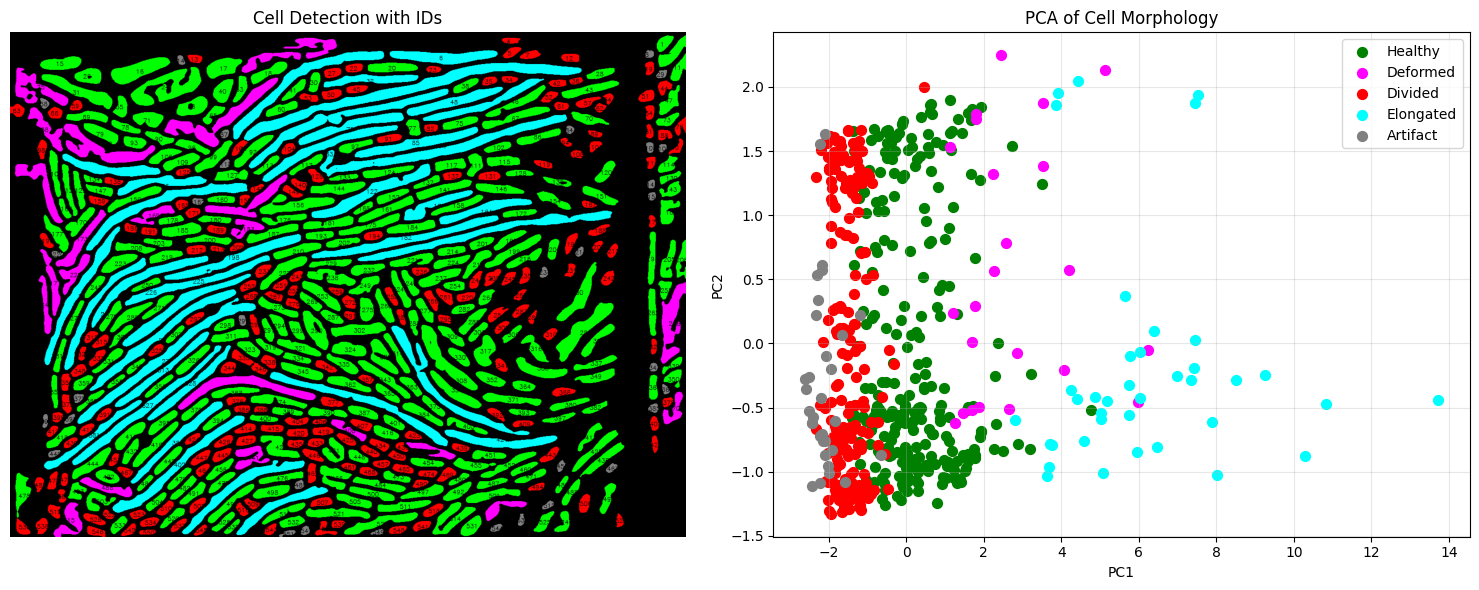

In [14]:
import cv2
from skimage.measure import label


def analyze_cells(original_image, binary_mask):
    """
    Simple cell analysis: extract metrics, classify, and visualize
    """
    from skimage.measure import regionprops, label
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import cv2
    
    # Get labeled regions
    labeled_image = label(binary_mask)
    
    # Extract cell data
    cell_data = []
    for region in regionprops(labeled_image, intensity_image=original_image):
        if region.area < 50:  # Skip small artifacts
            continue
            
        metrics = {
            "ID": region.label,
            "area": region.area,
            "perimeter": region.perimeter,
            "equivalent_diameter": region.equivalent_diameter,
            "orientation": region.orientation,
            "aspect_ratio": region.major_axis_length / region.minor_axis_length if region.minor_axis_length > 0 else 0,
            "circularity": (4 * np.pi * region.area) / (region.perimeter**2) if region.perimeter > 0 else 0,
            "solidity": region.solidity,
            "bbox": region.bbox  # (min_row, min_col, max_row, max_col)
        }
        
        # Use your exact classification thresholds
        area = metrics["area"]
        aspect_ratio = metrics["aspect_ratio"]
        circularity = metrics["circularity"]
        perimeter = metrics["perimeter"]
        solidity = metrics["solidity"]
        
        # Artifacts - extremely small objects
        if (area < 245.510 or perimeter < 65.901):
            metrics["morphology"] = "Artifact"
        
        # Divided Cells - recently divided cells
        elif (area < 685.844 and perimeter < 269.150 and aspect_ratio < 3.531):
            metrics["morphology"] = "Divided"
        
        # Healthy Cells - balanced morphology
        elif (0.516 <= circularity <= 0.727 and 
              1.463 <= aspect_ratio <= 3.292 and 
              solidity >= 0.880):
            metrics["morphology"] = "Healthy"
        
        # Elongated Cells - large area, high aspect ratio
        elif (area >= 2398.996 and 
              aspect_ratio >= 5.278 and 
              circularity <= 0.245):
            metrics["morphology"] = "Elongated"
        
        # Deformed Cells - low circularity and solidity
        elif (circularity <= 0.589 and solidity <= 0.706):
            metrics["morphology"] = "Deformed"
        
        # Default case
        else:
            metrics["morphology"] = "Healthy"
            
        cell_data.append(metrics)
    
    return pd.DataFrame(cell_data)

def visualize_analysis(original_image, df):
    """
    Show table, annotated image, and PCA plot
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    # Colors for each class
    colors = {
        "Artifact": "gray",
        "Divided": "red", 
        "Healthy": "green",
        "Elongated": "cyan",
        "Deformed": "magenta"
    }
    
    # 1. Show the table
    print("Cell Analysis Results:")
    display_df = df[['ID', 'area', 'perimeter', 'aspect_ratio', 'circularity', 'morphology']].round(2)
    print(display_df.to_string(index=False))
    
    # 2. Create annotated image with bounding boxes

    # Start with black background
    annotated_img = np.zeros((binary_mask.shape[0], binary_mask.shape[1], 3), dtype=np.uint8)

    # Get labeled regions
    labeled_image = label(binary_mask)

    # Color mapping
    color_map = {
        "Artifact": (128, 128, 128),
        "Divided": (255, 0, 0),
        "Healthy": (0, 255, 0), 
        "Elongated": (0, 255, 255),
        "Deformed": (255, 0, 255)
    }

    # Color each cell by its morphology class and add ID
    for _, row in df.iterrows():
        cell_id = int(row['ID'])
        color = color_map[row['morphology']]
        
        # Color all pixels belonging to this cell
        mask = (labeled_image == cell_id)
        annotated_img[mask] = color
        
        # Add ID text at the center of the cell
        y1, x1, y2, x2 = row['bbox']
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        cv2.putText(annotated_img, str(cell_id), (center_x-10, center_y+5), 
              cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)
    
    # 3. PCA Analysis
    numeric_cols = ['area', 'perimeter', 'equivalent_diameter', 'orientation', 'aspect_ratio', 'circularity', 'solidity']
    X = df[numeric_cols].values
    
    if len(df) > 1:  # Need at least 2 samples for PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(X_scaled)
        
        # Plot everything
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Annotated image
        axes[0].imshow(annotated_img)
        axes[0].set_title("Cell Detection with IDs")
        axes[0].axis('off')
        
        # PCA scatter plot
        for morphology in df['morphology'].unique():
            mask = df['morphology'] == morphology
            axes[1].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                          c=colors[morphology], label=morphology, s=50)
        
        axes[1].set_xlabel('PC1')
        axes[1].set_ylabel('PC2') 
        axes[1].set_title('PCA of Cell Morphology')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
    else:
        # Just show annotated image if not enough cells for PCA
        plt.figure(figsize=(8, 6))
        plt.imshow(annotated_img)
        plt.title("Cell Detection with IDs")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the analysis
cell_df = analyze_cells(normalized_frame, binary_mask)
visualize_analysis(normalized_frame, cell_df)

In [56]:
from cellpose import models
print(models.MODEL_NAMES)
model = models.CellposeModel(model_type="deepbacs_cp3")

['cyto3', 'nuclei', 'cyto2_cp3', 'tissuenet_cp3', 'livecell_cp3', 'yeast_PhC_cp3', 'yeast_BF_cp3', 'bact_phase_cp3', 'bact_fluor_cp3', 'deepbacs_cp3', 'cyto2', 'cyto', 'CPx', 'transformer_cp3', 'neurips_cellpose_default', 'neurips_cellpose_transformer', 'neurips_grayscale_cyto2', 'CP', 'CPx', 'TN1', 'TN2', 'TN3', 'LC1', 'LC2', 'LC3', 'LC4']
